## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import RobertaTokenizer
import transformers

from radam import RAdam
from text_data import BertDataset
from roberta import CustomRoberta
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [4]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [6]:
num_workers = 10
bs = 2

## Training model

In [7]:
lr = 1e-5
device = 'cuda'
n_epochs = 5
grad_accum = 1
weight_decay = 0.1
bert_output_dir = 'roberta_1_output/'
pretrained_model = 'siamese_roberta_1'
model_name = 'siamese_roberta_1_head'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
loss_fn = nn.BCEWithLogitsLoss()

In [8]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(get_optimizer_param_groups(model, lr, weight_decay))

def get_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomRoberta(256, cat_features_train.shape[1])
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model.head

Fold 1 started at Thu Jan 30 20:53:12 2020


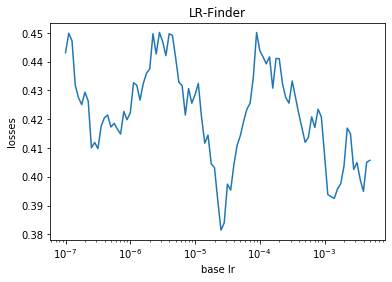

epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44962 - spearmanr 0.4247
best model: epoch -1 - 0.4247
epoch 0: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 0/5 	 train : loss 0.41767 - spearmanr 0.4977
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44779 - spearmanr 0.42673
best model: epoch 0 - 0.42673
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41625 - spearmanr 0.50079
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44762 - spearmanr 0.42729
best model: epoch 1 - 0.42729
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41584 - spearmanr 0.50103
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44763 - spearmanr 0.42759
best model: epoch 2 - 0.42759
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41492 - spearmanr 0.50369
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44771 - spearmanr 0.4277
best model: epoch 3 - 0.4277
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41455 - spearmanr 0.50394
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44765 - spearmanr 0.42776
best model: epoch 4 - 0.42776
TRAINING END: Best score achieved on epoch 4 - 0.42776
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_1_best.pth



Fold 2 started at Thu Jan 30 20:55:14 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45198 - spearmanr 0.42673
best model: epoch -1 - 0.42673
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41725 - spearmanr 0.49686
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45003 - spearmanr 0.4274
best model: epoch 0 - 0.4274
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41608 - spearmanr 0.49939
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45007 - spearmanr 0.4277
best model: epoch 1 - 0.4277
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41567 - spearmanr 0.50013
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.4504 - spearmanr 0.42805
best model: epoch 2 - 0.42805
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.4149 - spearmanr 0.50185
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45029 - spearmanr 0.42822
best model: epoch 3 - 0.42822
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41451 - spearmanr 0.50245
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45029 - spearmanr 0.42832
best model: epoch 4 - 0.42832
TRAINING END: Best score achieved on epoch 4 - 0.42832
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_2_best.pth



Fold 3 started at Thu Jan 30 20:57:12 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45692 - spearmanr 0.40985
best model: epoch -1 - 0.40985
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42515 - spearmanr 0.47866
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45238 - spearmanr 0.41193
best model: epoch 0 - 0.41193
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.4228 - spearmanr 0.48242
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45231 - spearmanr 0.41255
best model: epoch 1 - 0.41255
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.42166 - spearmanr 0.48537
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45246 - spearmanr 0.4124
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.42118 - spearmanr 0.48657
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45264 - spearmanr 0.41234
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.42051 - spearmanr 0.48825
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45272 - spearmanr 0.41234
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.41255
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_3_best.pth



Fold 4 started at Thu Jan 30 20:59:12 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45603 - spearmanr 0.39638
best model: epoch -1 - 0.39638
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41577 - spearmanr 0.50145
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45441 - spearmanr 0.39774
best model: epoch 0 - 0.39774
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41472 - spearmanr 0.50356
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45447 - spearmanr 0.39819
best model: epoch 1 - 0.39819
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41422 - spearmanr 0.5049
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45482 - spearmanr 0.39797
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.4136 - spearmanr 0.50595
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45472 - spearmanr 0.39794
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41305 - spearmanr 0.50784
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45486 - spearmanr 0.39799
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.39819
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_4_best.pth



Fold 5 started at Thu Jan 30 21:01:14 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45051 - spearmanr 0.40931
best model: epoch -1 - 0.40931
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.4163 - spearmanr 0.50109
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4476 - spearmanr 0.41142
best model: epoch 0 - 0.41142
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41505 - spearmanr 0.50351
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44771 - spearmanr 0.41183
best model: epoch 1 - 0.41183
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41442 - spearmanr 0.50461
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44793 - spearmanr 0.41187
best model: epoch 2 - 0.41187
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41379 - spearmanr 0.50638
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44791 - spearmanr 0.41194
best model: epoch 3 - 0.41194
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41337 - spearmanr 0.50716
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44789 - spearmanr 0.41176
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.41194
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_5_best.pth



Fold 6 started at Thu Jan 30 21:03:17 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44685 - spearmanr 0.40204
best model: epoch -1 - 0.40204
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41477 - spearmanr 0.50636
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4452 - spearmanr 0.4039
best model: epoch 0 - 0.4039
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41347 - spearmanr 0.50822
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44552 - spearmanr 0.40426
best model: epoch 1 - 0.40426
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.413 - spearmanr 0.50946
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44557 - spearmanr 0.40433
best model: epoch 2 - 0.40433
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41223 - spearmanr 0.51036
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44585 - spearmanr 0.40421
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.4118 - spearmanr 0.51179
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44584 - spearmanr 0.40428
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40433
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_6_best.pth



Fold 7 started at Thu Jan 30 21:05:18 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45332 - spearmanr 0.41841
best model: epoch -1 - 0.41841
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41689 - spearmanr 0.49762
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45152 - spearmanr 0.41974
best model: epoch 0 - 0.41974
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41579 - spearmanr 0.49962
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45168 - spearmanr 0.41993
best model: epoch 1 - 0.41993
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41542 - spearmanr 0.50038
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45176 - spearmanr 0.42001
best model: epoch 2 - 0.42001
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41458 - spearmanr 0.50244
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45194 - spearmanr 0.41963
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41432 - spearmanr 0.50256
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.4521 - spearmanr 0.41955
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42001
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_7_best.pth



Fold 8 started at Thu Jan 30 21:07:15 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45687 - spearmanr 0.42479
best model: epoch -1 - 0.42479
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41539 - spearmanr 0.50028
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45579 - spearmanr 0.42539
best model: epoch 0 - 0.42539
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41429 - spearmanr 0.50203
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45602 - spearmanr 0.42586
best model: epoch 1 - 0.42586
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.4136 - spearmanr 0.5033
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45627 - spearmanr 0.42588
best model: epoch 2 - 0.42588
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41297 - spearmanr 0.50433
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45669 - spearmanr 0.42596
best model: epoch 3 - 0.42596
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41251 - spearmanr 0.50603
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45683 - spearmanr 0.42612
best model: epoch 4 - 0.42612
TRAINING END: Best score achieved on epoch 4 - 0.42612
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_8_best.pth



Fold 9 started at Thu Jan 30 21:09:17 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45102 - spearmanr 0.41108
best model: epoch -1 - 0.41108
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41662 - spearmanr 0.499
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44874 - spearmanr 0.41311
best model: epoch 0 - 0.41311
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41534 - spearmanr 0.50111
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44897 - spearmanr 0.41381
best model: epoch 1 - 0.41381
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41473 - spearmanr 0.50237
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44916 - spearmanr 0.41431
best model: epoch 2 - 0.41431
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41421 - spearmanr 0.50345
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44906 - spearmanr 0.41451
best model: epoch 3 - 0.41451
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41369 - spearmanr 0.50501
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44915 - spearmanr 0.41489
best model: epoch 4 - 0.41489
TRAINING END: Best score achieved on epoch 4 - 0.41489
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_9_best.pth



Fold 10 started at Thu Jan 30 21:11:20 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44333 - spearmanr 0.41846
best model: epoch -1 - 0.41846
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.416 - spearmanr 0.50268
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4418 - spearmanr 0.41953
best model: epoch 0 - 0.41953
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41496 - spearmanr 0.50414
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44194 - spearmanr 0.41987
best model: epoch 1 - 0.41987
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41425 - spearmanr 0.50549
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44214 - spearmanr 0.41968
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41389 - spearmanr 0.50651
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44219 - spearmanr 0.41995
best model: epoch 3 - 0.41995
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41315 - spearmanr 0.50791
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44223 - spearmanr 0.41988
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.41995
Starting inference for model: checkpoints/siamese_roberta_1_head_fold_10_best.pth



OOF score: 0.4168766849146173


In [9]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    
    output_file_path = lambda mode: f'{bert_output_dir}{mode}_{pretrained_model}_fold_{fold_id+1}'
    train_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('train')}_q_outputs.npy"),
                    np.load(f"{output_file_path('train')}_a_outputs.npy"), train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('valid')}_q_outputs.npy"),
                    np.load(f"{output_file_path('valid')}_a_outputs.npy"), valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = get_model(fold_id)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-7, 
                             end_lr=1e-2, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=optim.lr_scheduler.StepLR(optimizer, n_epochs, 0.5), 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=False,
        eval_at_start=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
#     test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
#     preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [10]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.4945231974213355
5 4 0.4649977859325153
9 32 0.14703486044877231
11 4 0.7520157128683458
12 4 0.5531280755259124
13 4 0.2991416215704898
14 4 0.6509422004398637
15 4 0.5872682168808997
19 64 0.1700857058996728


In [11]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 32,  4,  4,  4,  4,  4, 64]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 19]))

In [12]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [13]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.416877
CV unique rows,0.382779
CV ignoring hard targets,0.441261
CV unique rows ignoring hard targets,0.404784
CV w rounding,0.450284
CV unique rows w rounding,0.428858
CV ignoring hard targets w rounding,0.471121
CV unique rows ignoring hard targets w rounding,0.443823


In [14]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.420892
CV unique rows,0.386858
CV ignoring hard targets,0.441261
CV unique rows ignoring hard targets,0.404784
CV w rounding,0.450808
CV unique rows w rounding,0.428858
CV ignoring hard targets w rounding,0.471121
CV unique rows ignoring hard targets w rounding,0.443823


In [15]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [16]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
1,46,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
2,70,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3,132,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
4,200,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001


In [17]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [18]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.797494,0.469874,0.248740,0.676456,0.525570,0.366000,0.617461,0.473001,0.083111,0.002545,0.688840,0.026301,0.487052,0.038047,0.007831,0.237879,0.151906,0.052585,0.497749,0.000529,0.740887,0.901669,0.565367,0.962397,0.946103,0.767920,0.075793,0.050442,0.888359,0.782633
1,0.845447,0.746005,0.065734,0.493176,0.935242,0.568008,0.599774,0.775699,0.485923,0.001892,0.278299,0.077526,0.711574,0.003555,0.896406,0.035920,0.038168,0.041898,0.326936,0.003395,0.806486,0.385512,0.248831,0.643074,0.735655,0.216312,0.023275,0.018612,0.274838,0.804873
2,0.616250,0.359057,0.007948,0.681680,0.788552,0.835993,0.425531,0.266313,0.091325,0.001410,0.402493,0.097983,0.005109,0.001361,0.001089,0.157006,0.780347,0.314786,0.134324,0.000091,0.642055,0.877343,0.598185,0.929251,0.928166,0.721704,0.800827,0.298919,0.397037,0.769591
3,0.807133,0.725275,0.045968,0.846523,0.921283,0.922103,0.552385,0.605658,0.290776,0.000879,0.100603,0.858981,0.025307,0.006328,0.189637,0.100856,0.010904,0.069200,0.511372,0.003415,0.737483,0.695973,0.674397,0.747985,0.780473,0.629758,0.013699,0.062901,0.822014,0.591369
4,0.774348,0.820090,0.003504,0.655431,0.830646,0.913288,0.483342,0.376149,0.140637,0.000303,0.276892,0.429776,0.001581,0.000338,0.000729,0.002796,0.853580,0.365518,0.093991,0.000013,0.829513,0.601746,0.326484,0.719937,0.763215,0.431863,0.842123,0.215569,0.030187,0.543426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.777792,0.421223,0.165999,0.815442,0.685004,0.623020,0.566382,0.520014,0.508834,0.005350,0.546113,0.911025,0.058996,0.217975,0.025258,0.102460,0.055503,0.086263,0.527065,0.001981,0.685310,0.864722,0.655497,0.924237,0.917004,0.660368,0.128000,0.128866,0.838342,0.729039
6075,0.830245,0.391645,0.150047,0.476384,0.530825,0.386211,0.664962,0.641371,0.128610,0.010417,0.703076,0.104424,0.030710,0.011079,0.002527,0.040618,0.780622,0.419556,0.172515,0.000590,0.688522,0.862313,0.550871,0.898016,0.927729,0.657484,0.861384,0.372572,0.258745,0.854316
6076,0.615788,0.361874,0.006365,0.640212,0.731097,0.879235,0.393198,0.306848,0.193163,0.004322,0.394028,0.545624,0.003341,0.002194,0.001104,0.008847,0.817834,0.396882,0.205183,0.000196,0.528455,0.554021,0.349795,0.746838,0.743812,0.351640,0.684383,0.247295,0.457534,0.398785
6077,0.832660,0.615882,0.633736,0.559238,0.386832,0.289516,0.578182,0.752554,0.412855,0.002130,0.847094,0.793109,0.095165,0.030966,0.017991,0.014277,0.009066,0.066592,0.706372,0.000310,0.836481,0.787753,0.653272,0.872772,0.885329,0.646888,0.006543,0.057557,0.885574,0.771234


In [19]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.384641
question_body_critical                   0.615869
question_conversational                  0.414206
question_expect_short_answer             0.309943
question_fact_seeking                    0.368724
question_has_commonly_accepted_answer    0.432089
question_interestingness_others          0.355869
question_interestingness_self            0.505319
question_multi_intent                    0.574933
question_not_really_a_question           0.085621
question_opinion_seeking                 0.486971
question_type_choice                     0.740475
question_type_compare                    0.366533
question_type_consequence                0.188114
question_type_definition                 0.365536
question_type_entity                     0.458990
question_type_instructions               0.782996
question_type_procedure                  0.378581
question_type_reason_explanation         0.675312
question_type_spelling                   0.065362


In [20]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.065362,3.0
question_not_really_a_question,0.085621,5.0
answer_plausible,0.164759,9.0
answer_relevance,0.181832,9.0
question_type_consequence,0.188114,5.0
answer_well_written,0.222056,9.0
answer_helpful,0.262027,9.0
question_expect_short_answer,0.309943,5.0
answer_type_procedure,0.322990,5.0
question_interestingness_others,0.355869,9.0


In [21]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

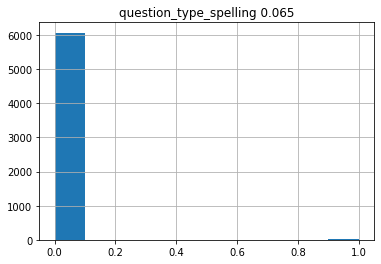

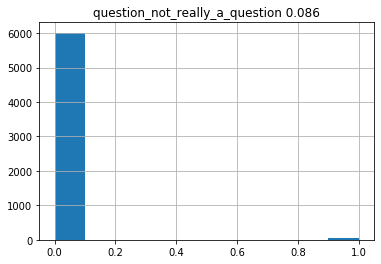

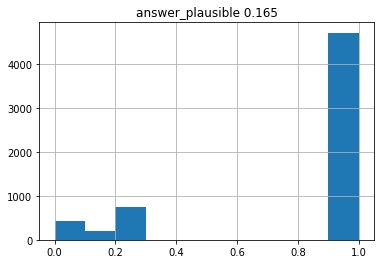

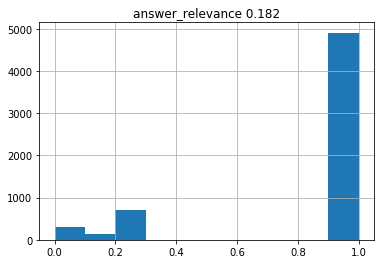

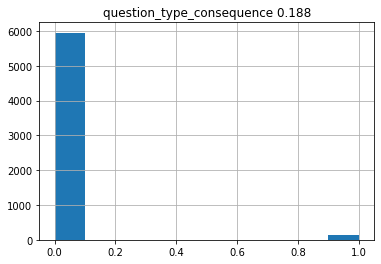

In [22]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


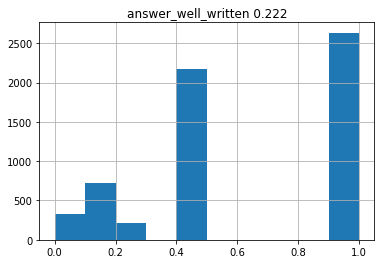

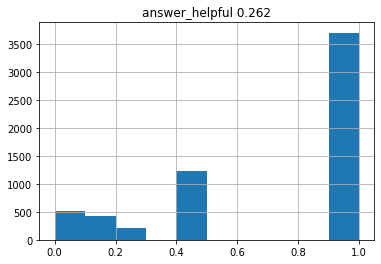

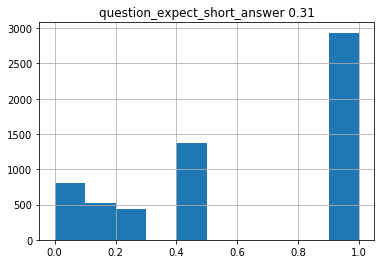

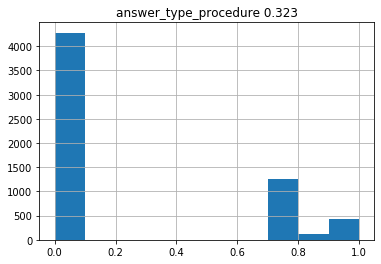

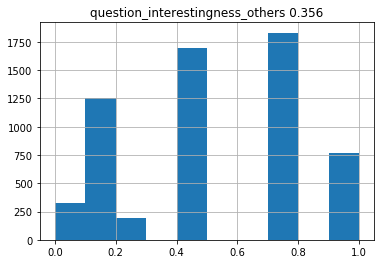

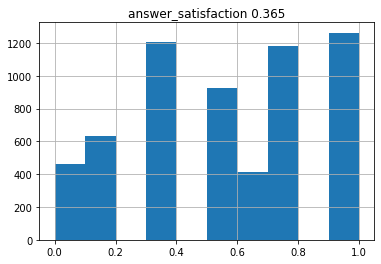

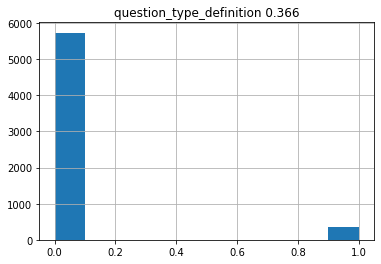

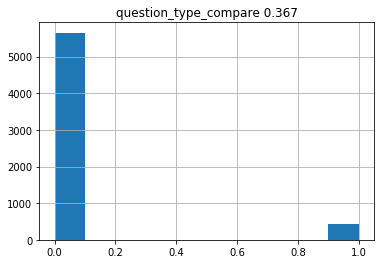

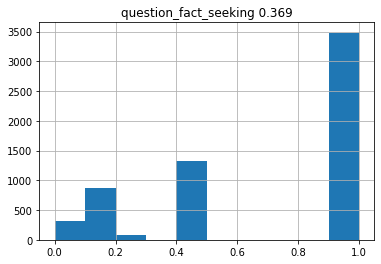

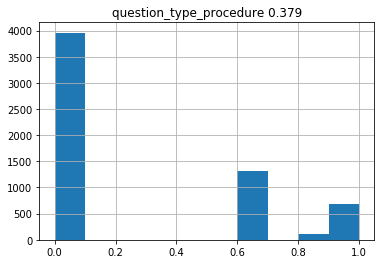

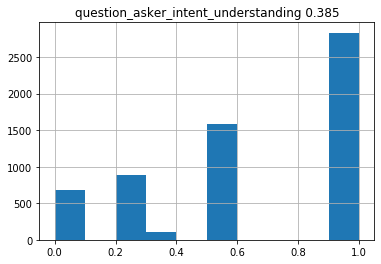

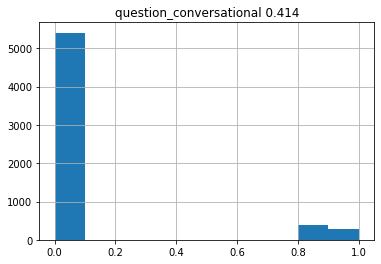

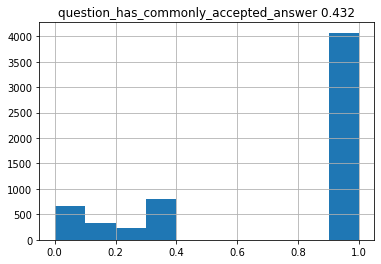

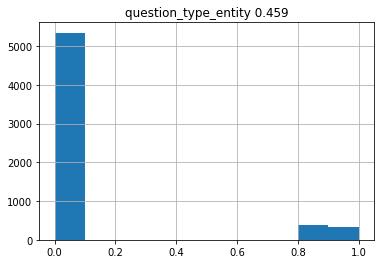

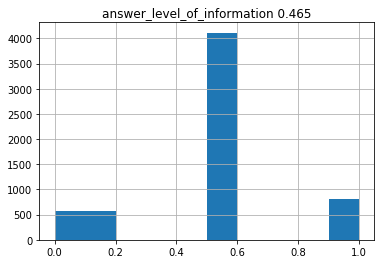

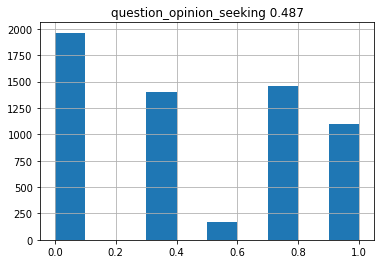

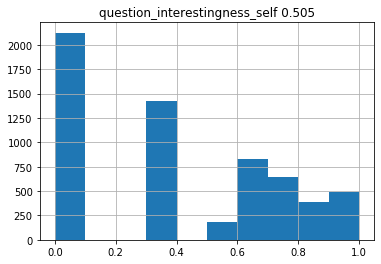

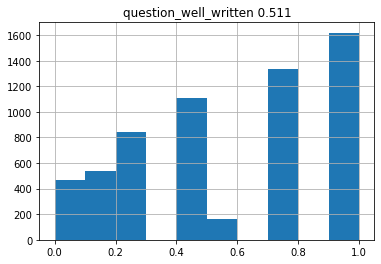

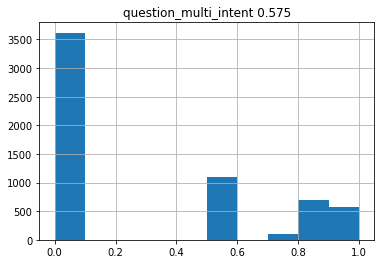

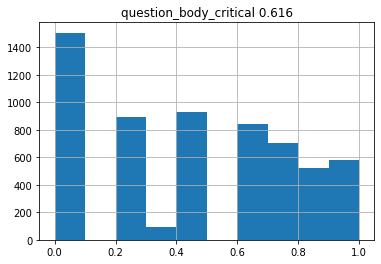

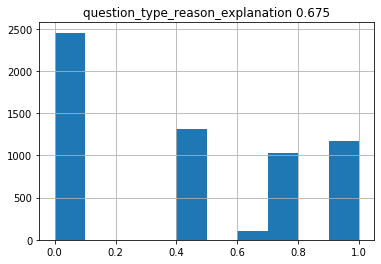

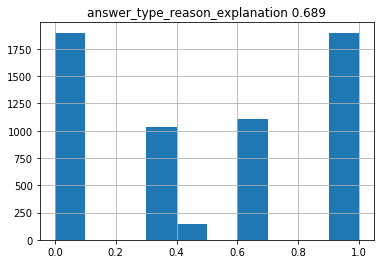

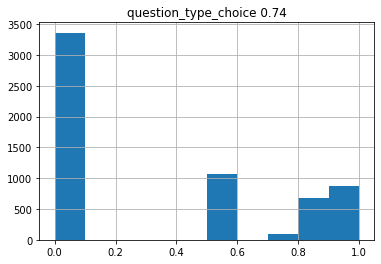

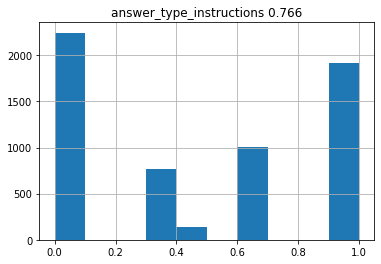

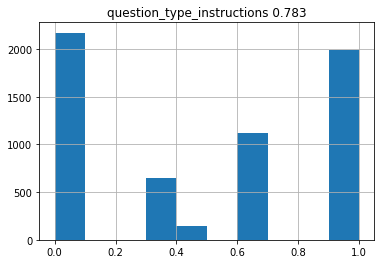

In [23]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')